In [6]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [7]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [10]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [11]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [25]:
# Find the most recent date in the data set.
most_recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent_date = dt.datetime.strptime(most_recent_date[0], '%Y-%m-%d')

In [51]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
prcp_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.date <= most_recent_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_data, columns=['Date', 'prcp'])
prcp_df



,Date,prcp
0,2016-08-24,0.08
1,2016-08-25,0.08
2,2016-08-26,0.00
3,2016-08-27,0.00
4,2016-08-28,0.01
...,...,...
2218,2017-08-19,0.09
2219,2017-08-20,NaN
2220,2017-08-21,0.56
2221,2017-08-22,0.50


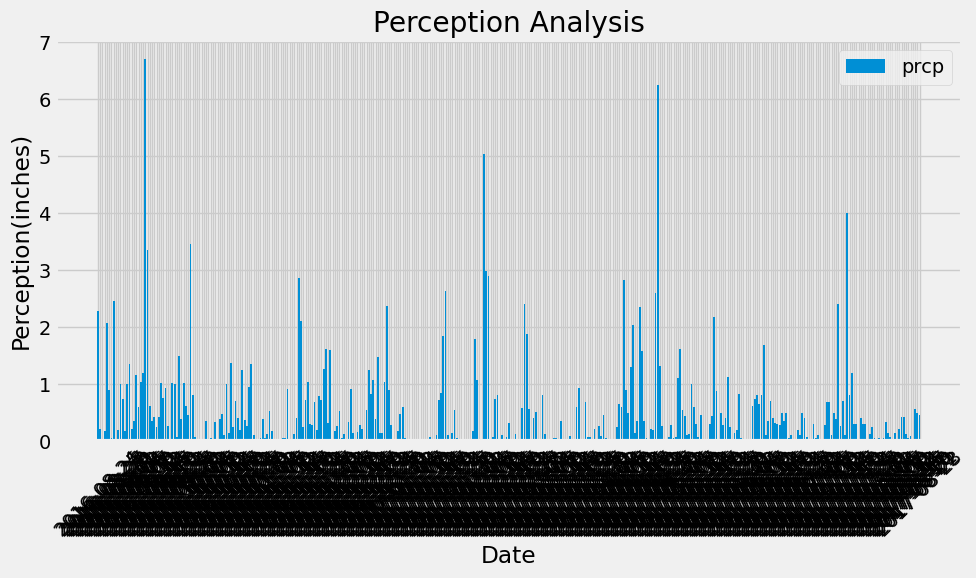

In [52]:
# Sort the dataframe by date
prcp_df.sort_values(by='Date', inplace=True)
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(10, 6))
plt.bar(prcp_df['Date'], prcp_df['prcp'], label='prcp')
plt.xlabel('Date')
plt.ylabel('Perception(inches)')
plt.title('Perception Analysis')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df.describe()
print(summary_statistics)

       Precipitation
count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()
print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()
print("Most active stations:")
for station, count in active_stations:
    print(f"Station {station}: {count} observations")


Most active stations:
Station USC00519281: 2772 observations
Station USC00519397: 2724 observations
Station USC00513117: 2709 observations
Station USC00519523: 2669 observations
Station USC00516128: 2612 observations
Station USC00514830: 2202 observations
Station USC00511918: 1979 observations
Station USC00517948: 1372 observations
Station USC00518838: 511 observations


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

Temperature statistics for station USC00519281:
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


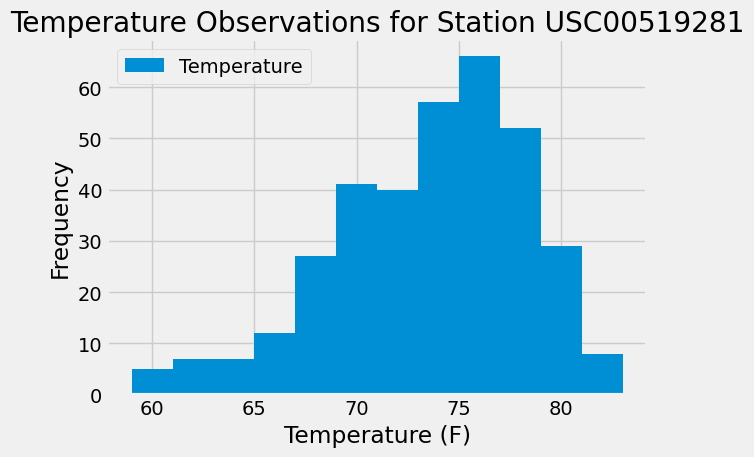

In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temperature_stats = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
    filter(Measurement.station == most_active_station).first()

print(f"Temperature statistics for station {most_active_station}:")
print(f"Lowest Temperature: {temperature_stats[0]}")
print(f"Highest Temperature: {temperature_stats[1]}")
print(f"Average Temperature: {temperature_stats[2]}")

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(Measurement.date, Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).\
    filter(Measurement.date <= most_recent_date).all()

# Save the query results as a Pandas DataFrame
temperature_df = pd.DataFrame(temperature_data, columns=['Date', 'Temperature'])

# Plot the temperature data as a histogram
plt.hist(temperature_df['Temperature'], bins=12, label='Temperature')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title(f'Temperature Observations for Station {most_active_station}')
plt.legend()
plt.tight_layout()
plt.show()

# Close Session

In [20]:
# Close Session
session.close()

In [39]:
from flask import Flask, jsonify

In [40]:
app = Flask(__name__)

In [41]:
# Define routes
@app.route("/")
def home():
    return (
        f"Welcome to the Climate Analysis API!<br/>"
        f"Available routes:<br/>"
        f"/api/v1.0/precipitation<br/>"
        f"/api/v1.0/stations<br/>"
        f"/api/v1.0/tobs<br/>"
        f"/api/v1.0/&lt;start&gt;<br/>"
        f"/api/v1.0/&lt;start&gt;/&lt;end&gt;<br/>"
    )

In [42]:
@app.route("/api/v1.0/precipitation")
def precipitation():
    session = Session(engine)
    most_recent_date = session.query(func.max(Measurement.date)).scalar()
    one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)
    prcp_data = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= one_year_ago).all()
    session.close()

    prcp_dict = {date: prcp for date, prcp in prcp_data}
    return jsonify(prcp_dict)


In [43]:
@app.route("/api/v1.0/stations")
def stations():
    session = Session(engine)
    station_list = session.query(Station.station).all()
    session.close()

    return jsonify(station_list)

In [44]:
@app.route("/api/v1.0/tobs")
def tobs():
    session = Session(engine)
    most_active_station = session.query(Measurement.station).\
        group_by(Measurement.station).\
        order_by(func.count(Measurement.station).desc()).first()[0]

    most_recent_date = session.query(func.max(Measurement.date)).scalar()
    one_year_ago = dt.datetime.strptime(most_recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

    temp_data = session.query(Measurement.date, Measurement.tobs).\
        filter(Measurement.station == most_active_station).\
        filter(Measurement.date >= one_year_ago).all()
    session.close()

    temp_list = [{"date": date, "temperature": temp} for date, temp in temp_data]
    return jsonify(temp_list)

In [45]:
@app.route("/api/v1.0/<start>")
@app.route("/api/v1.0/<start>/<end>")
def temperature_stats(start, end=None):
    session = Session(engine)

    if end is None:
        end = session.query(func.max(Measurement.date)).scalar()

    temp_stats = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start).\
        filter(Measurement.date <= end).all()
    session.close()

    temp_stats_dict = {
        "start_date": start,
        "end_date": end,
        "min_temperature": temp_stats[0][0],
        "avg_temperature": temp_stats[0][1],
        "max_temperature": temp_stats[0][2]
    }
    return jsonify(temp_stats_dict)

if __name__ == "__main__":
    app.run(debug=True)

 * Serving Flask app '__main__'
 * Debug mode: on


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
 * Restarting with watchdog (fsevents)
/Users/katieloosararian/anaconda3/envs/dev/lib/python3.10/site-packages/traitlets/traitlets.py:2544: FutureWarning: Supporting extra quotes around strings is deprecated in traitlets 5.0. You can use 'hmac-sha256' instead of '"hmac-sha256"' if you require traitlets >=5.
  warn(
/Users/katieloosararian/anaconda3/envs/dev/lib/python3.10/site-packages/traitlets/traitlets.py:2495: FutureWarning: Supporting extra quotes around Bytes is deprecated in traitlets 5.0. Use '2a784e51-7575-47af-8595-73f32ab37dfb' instead of 'b"2a784e51-7575-47af-8595-73f32ab37dfb"'.
  warn(
Traceback (most recent call last):
  File "/Users/katieloosararian/anaconda3/envs/dev/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/Users/katieloosararian/anaconda3/envs/dev/lib/python3.10/site-packages/traitlets/config/application.py", line 991, in launch_instance
   

SystemExit: 1